<a href="https://colab.research.google.com/github/LawTAGS/Deep-Learning-Classwork/blob/main/Assignments/Tugas_05_Deep_Learning_10121091_Bryan_Guok.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Identitas**#
**Nama  : Bryan Guok \
NIM   : 10121091**

#**1. Inisiasi Awal**#

##**Import Library**##

In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa.display
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import random

##**Set Seed**##

In [ ]:
# Set seed untuk reproducibility
SEED = 10121091
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

##**Unzip Data UrbanSound8K**##

In [ ]:
# Ubah direktori menjadi lokasi peletakkan file UrbanSound8K.zip
# !unzip '/content/drive/MyDrive/Tugas Deep Learning/UrbanSound8K.zip' -d '/content/'

# Install file menggunakan gdown incase tidak ada filenya
!pip install gdown

# Download file dari Google Drive
!gdown --id 1zwbnLT1ia7oICGq0NYeVYqaKUsfXQb7T -O UrbanSound8K.zip

# Unzip file ke /content/
!unzip UrbanSound8K.zip -d /content/


In [ ]:
# Path ke metadata csv
metadata_path = '/content/UrbanSound8K.csv'

# Baca metadata
import pandas as pd
data = pd.read_csv(metadata_path)
data.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


#**2. Preprocessing Data**#

In [ ]:
# Folder base
audio_dataset_path = '/content/'

# Mengkonversi audio .wav ke dalam bentuk spectogram dengan terlebih dahulu membuat
# fungsi untuk mengekstrak fitur
def extract_features(file_path): # Menggunakan library librosa untuk membuat spectogram
    try:
        audio, sample_rate = librosa.load(file_path, sr=22050)  # 22.05 kHz
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=128)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        return mel_spec_db
    except Exception as e:
        print("Error encountered while parsing file: ", file_path)
        return None

# Membuat array kosong untuk menampung fitur dan memberi label dari fitur
features = []
labels = []

# Melakukan iterasi untuk mengekstrak dari data suara UrbanSound8K kemudian memindahkan
# ke fitur ke array yang sudah disediakan serta memberi label masing2 fitur
for index, row in data.iterrows():
    file_name = os.path.join(audio_dataset_path, 'fold' + str(row["fold"]), row["slice_file_name"])
    class_label = row["class"]
    data_sample = extract_features(file_name)
    if data_sample is not None:
        features.append(data_sample)
        labels.append(class_label)

print(f"Jumlah data: {len(features)}")

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


Jumlah data: 8732


In [ ]:
# Resize semua spectrogram agar ukurannya sama karena bisa jadi ada suara yang
# lebih pendek atau panjang sehingga ukurannya berbeda
X = []
for feature in features:
    resized_feature = np.resize(feature, (128, 128))  # 128x128
    X.append(resized_feature)

# Me-reshape bentuk arraynya agar bisa dilakukan CNN dengan menambah 1 dimensi
X = np.array(X)
X = X[..., np.newaxis]  # Karena CNN dengan TensorFlow membutuhkan input berbentuk 4 dimensi
                        # sedangkan spektogram tadi hanya berbentuk 2 dimensi ditambah jumlah data menjadi 3 dimensi,
                        # maka kita perlu menambahkan dimensi agar ukurannya sesuai

# Encode labels
le = LabelEncoder()
y = le.fit_transform(labels)
y = np.array(y)

print("Shape X:", X.shape)
print("Shape y:", y.shape)

Shape X: (8732, 128, 128, 1)
Shape y: (8732,)


#**3. Training CNN**#

##**Splitting Data**##

In [ ]:
# Data akan di train dengan ketentuan ukuran test 20%, 80% sebagai training data
# dan ke-random-an nya berdasarkan NIM
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
print("Jumlah data train:", len(X_train))
print("Jumlah data test:", len(X_test))

Jumlah data train: 6985
Jumlah data test: 1747


##**Membuat Model CNN**##

In [ ]:
# Membuat model CNN dengan aktivasi relu
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 1)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(np.unique(y)), activation='softmax')
])

# Meng-compile model menggunakan optimizer Adam
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,354 (12.61 MB)

 Trainable params: 3,305,354 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

##**Training Data**##

In [ ]:
# Melakukan training dengan memfitting data yang sudah ada ke model CNN
history = model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=32,
                    validation_data=(X_test, y_test))

Epoch 1/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 252s 1s/step - accuracy: 0.2095 - loss: 3.9520 - val_accuracy: 0.3526 - val_loss: 1.7076
Epoch 2/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.3605 - loss: 1.7352 - val_accuracy: 0.4121 - val_loss: 1.5841
Epoch 3/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 283s 1s/step - accuracy: 0.4752 - loss: 1.4921 - val_accuracy: 0.5249 - val_loss: 1.3404
Epoch 4/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 286s 1s/step - accuracy: 0.5844 - loss: 1.2527 - val_accuracy: 0.6291 - val_loss: 1.0926
Epoch 5/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 259s 1s/step - accuracy: 0.6550 - loss: 1.0369 - val_accuracy: 0.5947 - val_loss: 1.1445
Epoch 6/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 270s 1s/step - accuracy: 0.7028 - loss: 0.9075 - val_accuracy: 0.6817 - val_loss: 0.9574
Epoch 7/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 255s 1s/step - accuracy: 0.7429 - loss: 0.7890 - val_accuracy: 0.7275 - val_loss: 0.8739
Epoch 8/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 268s 1s/step - accuracy: 0.7781 - loss: 0.6609 - val_accu

#**4. Hasil**#

##**Grafik Akurasi**##

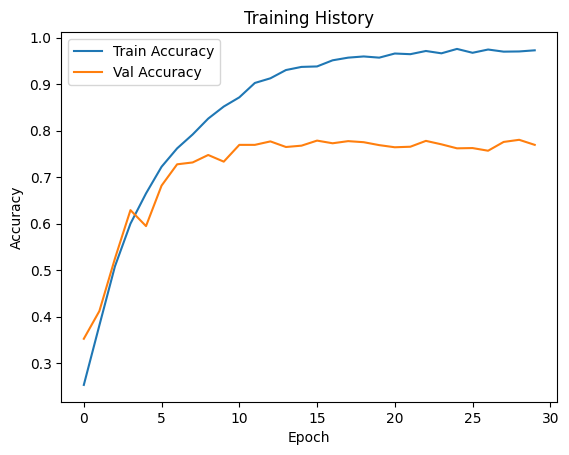

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training History')
plt.show()

##**Loss**##

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")

55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 290ms/step - accuracy: 0.7709 - loss: 1.4164
Test Accuracy: 76.93%


#**5. Prediksi**#

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes, target_names=le.classes_))

55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 287ms/step
                  precision    recall  f1-score   support

 air_conditioner       0.86      0.80      0.83       200
        car_horn       0.67      0.67      0.67        86
children_playing       0.65      0.71      0.68       200
        dog_bark       0.67      0.74      0.70       200
        drilling       0.81      0.73      0.77       200
   engine_idling       0.86      0.88      0.87       200
        gun_shot       0.69      0.85      0.76        75
      jackhammer       0.80      0.84      0.82       200
           siren       0.92      0.78      0.85       186
    street_music       0.72      0.67      0.69       200

        accuracy                           0.77      1747
       macro avg       0.76      0.77      0.76      1747
    weighted avg       0.78      0.77      0.77      1747

